# Geodata preprocessing I - Prepare stands and roads data

In [1]:
# import 
import os
import re

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import networkx as nx

import random

## Prep A. Previously existing roads

### Step 0. Load shapefile Roads into gdf

In [2]:
# load shapefile into geodataframe roads
roads = gpd.read_file('0_Received_Data/2-Public_Road_Network/RVF_CPv_clip.shp')
#print('shapefile loaded, gdf shape:', roads.shape)
#print(roads.columns)
print(roads.head(2))

   Id  ID_RV  DATA_ACCAO COD_INE      DESIGNACAO OPERAC  REDE_DFCI TIPO_PISO  \
0   1      1  2011-01-31   10609  VARIANTE EN222   OPER          1         A   
1   2      2  2011-02-01   10606  VARIANTE EN222   OPER          1         A   

   COMPRIM  LARGURA  ... EXEC_2017  FIN_2017  FASE_2017  TIPO_VEICU  \
0  1398.32      0.0  ...         0         0          0        VTTR   
1  2022.46      0.0  ...         0         0          0        VTTR   

  INTER_2018  EXEC_2018  FIN_2018  FASE_2018 OBSERV  \
0        ESI          0         0          0    NaN   
1        ESI          0         0          0    NaN   

                                            geometry  
0  LINESTRING (188412.234 451778.189, 188385.778 ...  
1  LINESTRING (187762.919 451514.505, 187765.435 ...  

[2 rows x 33 columns]


### Basic EDA

In [3]:
print(roads.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Id          311 non-null    int64   
 1   ID_RV       311 non-null    int64   
 2   DATA_ACCAO  311 non-null    object  
 3   COD_INE     311 non-null    object  
 4   DESIGNACAO  311 non-null    object  
 5   OPERAC      311 non-null    object  
 6   REDE_DFCI   311 non-null    int64   
 7   TIPO_PISO   310 non-null    object  
 8   COMPRIM     311 non-null    float64 
 9   LARGURA     311 non-null    float64 
 10  INTER_2014  311 non-null    object  
 11  EXEC_2014   311 non-null    int64   
 12  FIN_2014    311 non-null    int64   
 13  FASE_2014   311 non-null    int64   
 14  INTER_2015  311 non-null    object  
 15  EXEC_2015   311 non-null    int64   
 16  FIN_2015    311 non-null    int64   
 17  FASE_2015   311 non-null    int64   
 18  INTER_2016  311 non-null    object  
 19  

In [4]:
roads.columns

Index(['Id', 'ID_RV', 'DATA_ACCAO', 'COD_INE', 'DESIGNACAO', 'OPERAC',
       'REDE_DFCI', 'TIPO_PISO', 'COMPRIM', 'LARGURA', 'INTER_2014',
       'EXEC_2014', 'FIN_2014', 'FASE_2014', 'INTER_2015', 'EXEC_2015',
       'FIN_2015', 'FASE_2015', 'INTER_2016', 'EXEC_2016', 'FIN_2016',
       'FASE_2016', 'INTER_2017', 'EXEC_2017', 'FIN_2017', 'FASE_2017',
       'TIPO_VEICU', 'INTER_2018', 'EXEC_2018', 'FIN_2018', 'FASE_2018',
       'OBSERV', 'geometry'],
      dtype='object')

In [5]:
print(roads.head())

   Id  ID_RV  DATA_ACCAO COD_INE      DESIGNACAO OPERAC  REDE_DFCI TIPO_PISO  \
0   1      1  2011-01-31   10609  VARIANTE EN222   OPER          1         A   
1   2      2  2011-02-01   10606  VARIANTE EN222   OPER          1         A   
2   3      3  2011-02-01   10603  VARIANTE EN222   OPER          1         A   
3   4      4  2011-02-01   10607  VARIANTE EN222   OPER          1         A   
4   5      5  2011-02-01   10603  VARIANTE EN222   OPER          1         A   

   COMPRIM  LARGURA  ... EXEC_2017  FIN_2017  FASE_2017  TIPO_VEICU  \
0  1398.32      0.0  ...         0         0          0        VTTR   
1  2022.46      0.0  ...         0         0          0        VTTR   
2    68.72      0.0  ...         0         0          0        VTTR   
3  1298.56      0.0  ...         0         0          0        VTTR   
4   286.72      0.0  ...         0         0          0        VTTR   

  INTER_2018  EXEC_2018  FIN_2018  FASE_2018 OBSERV  \
0        ESI          0         0    

In [6]:
print(roads.describe())

               Id       ID_RV   REDE_DFCI       COMPRIM     LARGURA  \
count  311.000000  311.000000  311.000000    311.000000  311.000000   
mean   157.173633  157.173633    2.324759   1255.446527    2.352090   
std     90.874189   90.874189    0.838969   1273.179944    1.532125   
min      1.000000    1.000000    1.000000      4.080000    0.000000   
25%     79.500000   79.500000    2.000000    483.820000    2.000000   
50%    157.000000  157.000000    3.000000    943.730000    2.500000   
75%    234.500000  234.500000    3.000000   1498.910000    3.500000   
max    319.000000  319.000000    3.000000  11066.330000    7.500000   

        EXEC_2014    FIN_2014   FASE_2014   EXEC_2015    FIN_2015  ...  \
count  311.000000  311.000000  311.000000  311.000000  311.000000  ...   
mean     0.260450    0.372990    0.064309    0.077170    0.115756  ...   
std      0.996613    1.442146    0.245697    0.551092    0.826639  ...   
min      0.000000    0.000000    0.000000    0.000000    0.00000

In [7]:
print(roads.isnull().sum())

Id              0
ID_RV           0
DATA_ACCAO      0
COD_INE         0
DESIGNACAO      0
OPERAC          0
REDE_DFCI       0
TIPO_PISO       1
COMPRIM         0
LARGURA         0
INTER_2014      0
EXEC_2014       0
FIN_2014        0
FASE_2014       0
INTER_2015      0
EXEC_2015       0
FIN_2015        0
FASE_2015       0
INTER_2016      0
EXEC_2016       0
FIN_2016        0
FASE_2016       0
INTER_2017      0
EXEC_2017       0
FIN_2017        0
FASE_2017       0
TIPO_VEICU      0
INTER_2018      0
EXEC_2018       0
FIN_2018        0
FASE_2018       0
OBSERV        311
geometry        0
dtype: int64


In [8]:
# Check the CRS
print(roads.crs)

PROJCS["Lisboa_Hayford_Gauss_IGeoE",GEOGCS["GCS_Datum_Lisboa_Hayford",DATUM["D_Datum_Lisboa_Hayford",SPHEROID["International 1924",6378388,297,AUTHORITY["EPSG","7022"]],AUTHORITY["ESRI","106263"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["ESRI","104106"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",39.6666666666667],PARAMETER["central_meridian",-8.13190611111111],PARAMETER["scale_factor",1],PARAMETER["false_easting",200000],PARAMETER["false_northing",300000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102164"]]


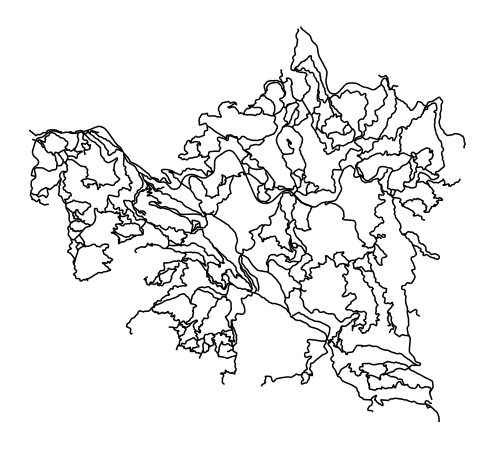

In [9]:
# Plot the geometries
ax = roads.plot(figsize=(10, 8), edgecolor='black')
ax.axis('off')  # Turn off the axes, including labels and ticks
plt.show()

In [10]:
# value counts for categorical variables
print("Value counts for ...")
for col in ['OPERAC','TIPO_PISO','LARGURA','TIPO_VEICU']:
    print(f"\n{col}:")
    print(roads[col].value_counts())

Value counts for ...

OPERAC:
OPER    298
INOP     13
Name: OPERAC, dtype: int64

TIPO_PISO:
A    172
T    138
Name: TIPO_PISO, dtype: int64

LARGURA:
0.0    70
2.0    62
4.0    54
3.0    46
2.5    38
3.5    22
4.5     5
5.0     5
1.5     5
5.5     1
6.5     1
7.5     1
7.0     1
Name: LARGURA, dtype: int64

TIPO_VEICU:
VFCI    234
VTTR     77
Name: TIPO_VEICU, dtype: int64


### Road Operability

OPER    298
INOP     13
Name: OPERAC, dtype: int64


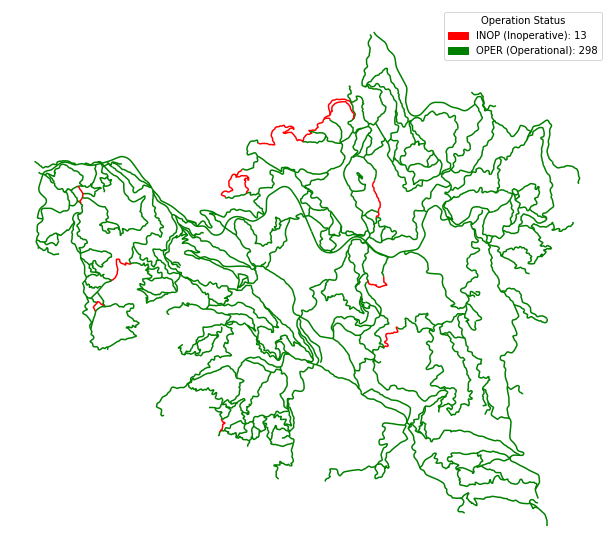

In [11]:
print(roads['OPERAC'].value_counts())

# Define a color map for 'OPERAC' where 'INOP' is red and 'OPER' is green
color_map = {'INOP': 'red', 'OPER': 'green'}

# Plot the road geometries with specific colors based on the 'OPERAC' status
fig, ax = plt.subplots(figsize=(12, 10))
roads.plot(color=roads['OPERAC'].map(color_map), ax=ax)

# Create a custom legend for the operation statuses

handles = [
    mpatches.Patch(color='red', label=f'INOP (Inoperative): {roads.OPERAC.value_counts()[1]}'),
    mpatches.Patch(color='green', label=f'OPER (Operational): {roads.OPERAC.value_counts()[0]}')
]
ax.legend(handles=handles, title='Operation Status')
ax.axis('off')
#plt.title('Roads Colored by Operation Status ("OPERAC")')
plt.show()


#### Inoperative roads

In [12]:
# look at ioperative roads
inop = roads[roads['OPERAC'] == 'INOP']
print(len(inop))
inop.head(1)

13


Id  ID_RV  DATA_ACCAO COD_INE DESIGNACAO OPERAC  REDE_DFCI TIPO_PISO  \
144  145    145  2011-11-15   10603        RVF   INOP          3         T   

     COMPRIM  LARGURA  ... EXEC_2017  FIN_2017  FASE_2017  TIPO_VEICU  \
144   456.35      2.0  ...         0         0          0        VFCI   

    INTER_2018  EXEC_2018  FIN_2018  FASE_2018 OBSERV  \
144        MAN          4         6          1    NaN   

                                              geometry  
144  LINESTRING (182507.875 446274.883, 182508.608 ...  

[1 rows x 33 columns]

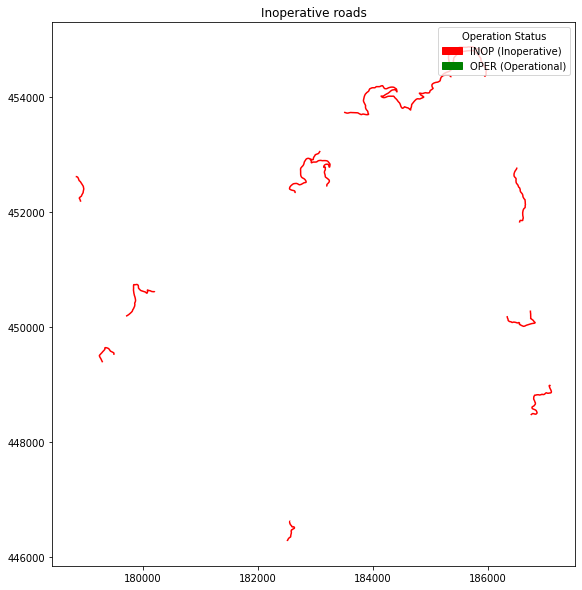

In [13]:
# plot inoperative roads
fig, ax = plt.subplots(figsize=(12, 10))
inop.plot(color=inop['OPERAC'].map(color_map), ax=ax)

# Create a custom legend for the operation statuses
handles = [
    mpatches.Patch(color='red', label='INOP (Inoperative)'),
    mpatches.Patch(color='green', label='OPER (Operational)')
]
ax.legend(handles=handles, title='Operation Status')

plt.title('Inoperative roads')
plt.show()

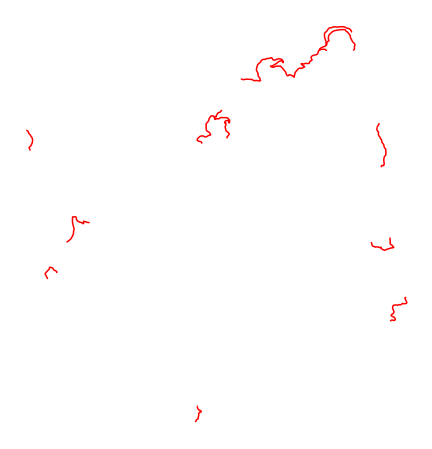

In [14]:
# Plot the geometries
ax = inop.plot(figsize=(10, 8), edgecolor='red')
ax.axis('off')  # Turn off the axes, including labels and ticks
plt.show()

### Step 1. Remove inoperative roads

OPER    298
Name: OPERAC, dtype: int64


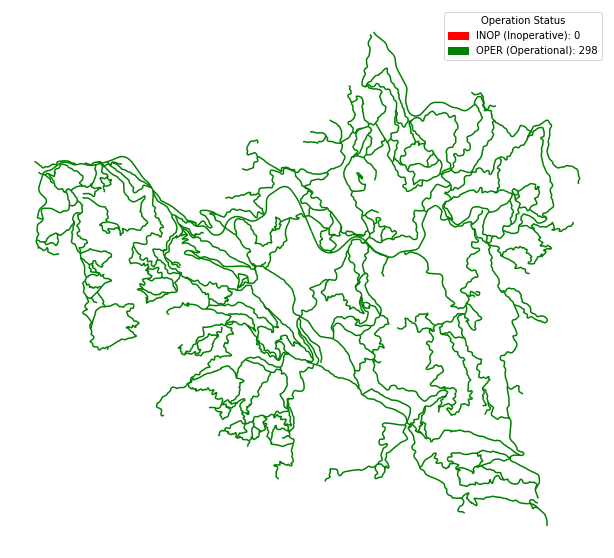

In [15]:
# Remove inoperative roads
roads = roads[roads['OPERAC'] != 'INOP']

# Verify the count after removal
print(roads['OPERAC'].value_counts())

# Define a color map for 'OPERAC' where 'INOP' is red and 'OPER' is green
color_map = {'INOP': 'red', 'OPER': 'green'}

# Plot the road geometries with specific colors based on the 'OPERAC' status
fig, ax = plt.subplots(figsize=(12, 10))
roads.plot(color=roads['OPERAC'].map(color_map), ax=ax)

# Create a custom legend for the operation statuses

handles = [
    mpatches.Patch(color='red', label=f'INOP (Inoperative): 0'),
    mpatches.Patch(color='green', label=f'OPER (Operational): {roads.OPERAC.value_counts()[0]}')
]
ax.legend(handles=handles, title='Operation Status')
ax.axis('off')

#plt.title('Roads Colored by Operation Status ("OPERAC")')
plt.show()

### Road Surface

In [16]:
roads[roads.TIPO_PISO.isna()]

Id  ID_RV  DATA_ACCAO COD_INE DESIGNACAO OPERAC  REDE_DFCI TIPO_PISO  \
81  82     82  2011-03-31    1060        REM   OPER          2       NaN   

    COMPRIM  LARGURA  ... EXEC_2017  FIN_2017  FASE_2017  TIPO_VEICU  \
81   934.14      4.0  ...         0         0          0        VFCI   

   INTER_2018  EXEC_2018  FIN_2018  FASE_2018 OBSERV  \
81        ESI          0         0          0    NaN   

                                             geometry  
81  LINESTRING (189823.849 451456.845, 189817.994 ...  

[1 rows x 33 columns]

A    172
T    125
Name: TIPO_PISO, dtype: int64
NaN  1


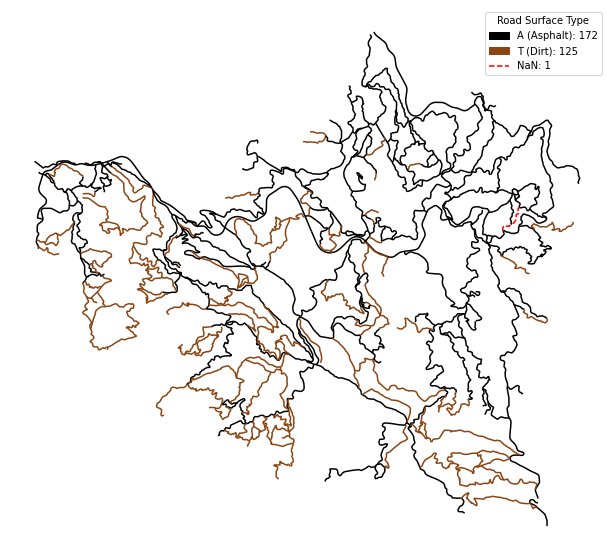

In [17]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Display the count of each road surface type in the 'TIPO_PISO' column
print(roads.TIPO_PISO.value_counts())
print('NaN ', roads.TIPO_PISO.isna().sum())

roads.plot(
    color=roads.TIPO_PISO.apply(lambda x: 'black' if x=='A'
                                else 'saddlebrown' if x=='T'
                                else 'red'),
    linestyle=roads['TIPO_PISO'].apply(lambda x: '--' if pd.isna(x) else '-'),
    ax=ax
)

# Create a custom legend for the road surface types

handles = [
    mpatches.Patch(color='black', label=f'A (Asphalt): {roads.TIPO_PISO.value_counts()[0]}'),
    mpatches.Patch(color='saddlebrown', label=f'T (Dirt): {roads.TIPO_PISO.value_counts()[1]}'),
    Line2D([0], [0], color='red', linestyle='--', label=f'NaN: {roads.TIPO_PISO.isna().sum()}')  # Adding dashed style for unknown
]
ax.legend(handles=handles, title='Road Surface Type')
ax.axis('off')

#plt.title('Roads Colored by Surface Type ("TIPO_PISO")')
plt.show()


### Rede DFCI

In [18]:
# Frequency Table
pd.crosstab(index=[roads['DESIGNACAO'], roads['TIPO_PISO']], 
                               columns=roads['REDE_DFCI'])

REDE_DFCI                  1   2   3
DESIGNACAO     TIPO_PISO            
EN222          A           7   0   0
EN224          A          10   0   0
REM            A          43  48  42
               T           0   5  18
RVF            A           0   2   7
               T           2   4  96
VARIANTE EN108 A           4   0   0
VARIANTE EN222 A           9   0   0

3    163
1     75
2     60
Name: REDE_DFCI, dtype: int64


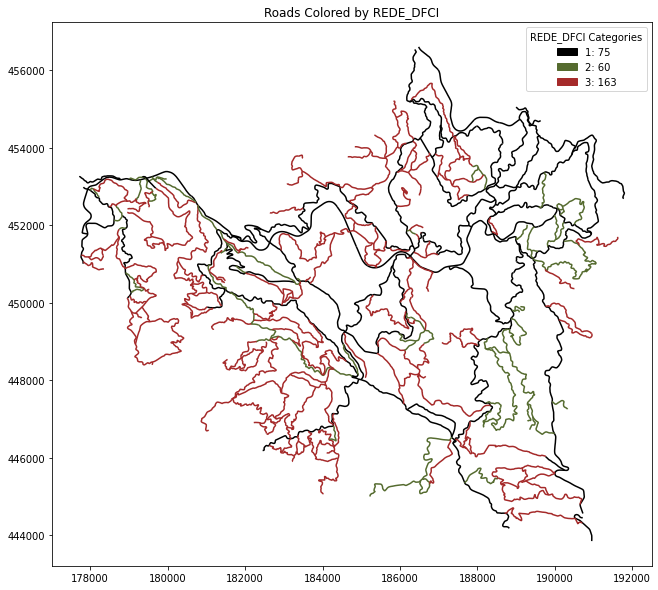

In [19]:
print(roads['REDE_DFCI'].value_counts())

# Define a color map for the 'REDE_DFCI' categories
color_map = {
    1: 'black',    # grey for National Roads
    2: '#556B2F',     # Olive Green for Municipal Roads
    3: 'brown'
}

# Apply the color map to the 'REDE_DFCI' column
roads['color'] = roads['REDE_DFCI'].map(color_map)

# Plot the road geometries with specific colors based on the 'REDE_DFCI' values
fig, ax = plt.subplots(figsize=(12, 10))
roads.plot(color=roads['color'], ax=ax)

# Create a custom legend for the categories
handles = [
    mpatches.Patch(color='black', label = f"1: {roads.REDE_DFCI.value_counts()[1]}"),  
    mpatches.Patch(color='#556B2F', label = f"2: {roads.REDE_DFCI.value_counts()[2]}"), 
    mpatches.Patch(color='brown', label = f"3: {roads.REDE_DFCI.value_counts()[3]}")       
]
ax.legend(handles=handles, title='REDE_DFCI Categories')
plt.title('Roads Colored by REDE_DFCI')
plt.show()

### Vehicle suitability TIPO_VEICO

VFCI    221
VTTR     77
Name: TIPO_VEICU, dtype: int64


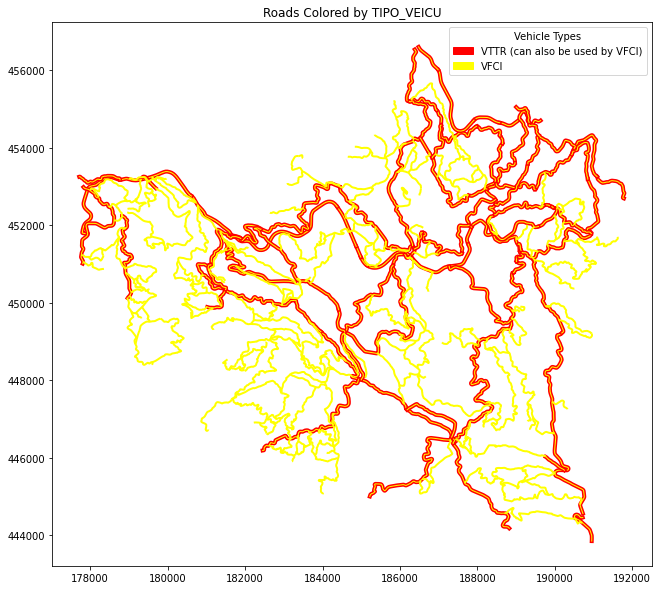

In [20]:
# Display the count of each category in the 'TIPO_VEICU' column
print(roads['TIPO_VEICU'].value_counts())

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Separate the data into two DataFrames based on 'TIPO_VEICU'
vttr_roads = roads[roads['TIPO_VEICU'] == 'VTTR']
vfci_roads = roads[roads['TIPO_VEICU'] == 'VFCI']

# Plot the VTTR roads with double stripes (red and yellow)
for geom in vttr_roads.geometry:
    ax.plot(*geom.xy, color='red', linewidth=4)  # Outer line (red)
    ax.plot(*geom.xy, color='yellow', linewidth=1, alpha=1)  # Inner line (yellow, dashed)

# Plot the VFCI roads as solid lines
vfci_roads.plot(color='yellow', ax=ax, linewidth=2)  # You can change 'blue' to any color of your choice

# Create a custom legend for the categories
handles = [
    mpatches.Patch(color='red', label='VTTR (can also be used by VFCI)'),  # Color for VTTR
    mpatches.Patch(color='yellow', label='VFCI')  # Color for VFCI
]

ax.legend(handles=handles, title='Vehicle Types')
plt.title('Roads Colored by TIPO_VEICU')
plt.show()

### Road Width

In [21]:
Largura_values = roads.LARGURA.value_counts()

# Convert to a DataFrame for tabular representation
Largura_values_df = Largura_values.reset_index()
Largura_values_df.columns = ['LARGURA [m]', 'Count']

print(Largura_values_df)

    LARGURA [m]  Count
0           0.0     70
1           4.0     54
2           2.0     54
3           3.0     45
4           2.5     38
5           3.5     22
6           4.5      5
7           5.0      5
8           5.5      1
9           6.5      1
10          1.5      1
11          7.5      1
12          7.0      1


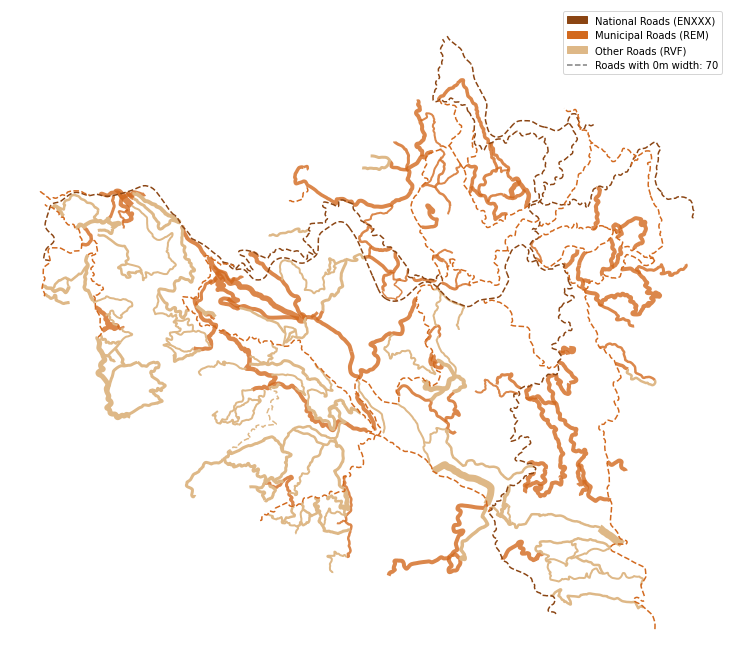

In [22]:
scaling_factor = 1

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(14, 12))

# Plot the roads with LARGURA > 0 as solid black lines sized by their width
#roads[roads.LARGURA > 0].plot(color='black', linewidth=roads.LARGURA * scaling_factor, ax=ax, label='Roads (Largura > 0)', legend=True)

# Plot national roads (ENXXX) as solid lines sized by their width
roads[roads['DESIGNACAO'].str.contains('EN')].plot(
    color='saddlebrown',
    linewidth=roads[roads['DESIGNACAO'].str.contains('EN')]['LARGURA'] * scaling_factor,
    alpha=.8, ax=ax, label='National Roads (ENXXX)')

# Plot municipal roads (REM) as solid lines sized by their width
roads[roads['DESIGNACAO']=='REM'].plot(
    color='chocolate',
    linewidth=roads[roads['DESIGNACAO'] == 'REM']['LARGURA'] * scaling_factor,
    alpha=.8, ax=ax, label='Municipal Roads (REM)')

# Plot other roads (RVF) as  solid lines sized by their width
roads[roads['DESIGNACAO']=='RVF'].plot(
    color='burlywood',
    linewidth=roads[roads['DESIGNACAO'] == 'RVF']['LARGURA'] * scaling_factor,
    ax=ax, label='Other Roads (RVF)')

# Plot the roads with LARGURA = 0 as thin dashed lines
#roads[roads.LARGURA == 0].plot(color='grey', linewidth=1, linestyle='--', ax=ax, label='Roads (Largura = 0)')
# Plot the roads with LARGURA = 0 as thin dashed lines
roads[(roads['DESIGNACAO'].str.contains('EN')) & (roads.LARGURA == 0)].plot(
    color='saddlebrown',
    alpha=1, ax=ax, label='National Roads (ENXXX)', linestyle='--'
)

roads[(roads['DESIGNACAO'] == 'REM') & (roads.LARGURA == 0)].plot(
    color='chocolate',
    alpha=1, ax=ax, label='Municipal Roads (REM)', linestyle='--'
)

roads[(roads['DESIGNACAO'] == 'RVF') & (roads.LARGURA == 0)].plot(
    color='burlywood',
    alpha=1, ax=ax, label='Other Roads (RVF)', linestyle='--'
)


# Create a custom legend for the categories
handles = handles = [
    mpatches.Patch(color='saddlebrown', label='National Roads (ENXXX)'),
    mpatches.Patch(color='chocolate', label='Municipal Roads (REM)'),
    mpatches.Patch(color='burlywood', label='Other Roads (RVF)'),
    Line2D([0], [0], color='grey', linestyle='--', label=f'Roads with 0m width: {len(roads[roads.LARGURA == 0])}')  # Adding dashed style for unknown
]   
ax.legend(handles=handles)
ax.axis('off')

# Add title
#plt.title('Roads Colored Black and Sized by Width ("Largura")')
plt.show()

### Step 2. Assign new road width values based on standards
We use the Road Width Standards by DESIGNACAO:
- *ENXXX* or *Variante de ENXXX* (national roads) are assumed to have a width of 10m.
- *REM* (municipal roads) are assumed to have a width of 6m.
- *RVF* roads are assumed to have a width of 3m.

In [23]:
# Assuming 'roads' is your pandas DataFrame
unique_designacao_values = roads['DESIGNACAO'].unique()

# Print the unique values
print(unique_designacao_values)


['VARIANTE EN222' 'EN224' 'VARIANTE EN108' 'EN222' 'REM' 'RVF']


In [24]:
roads.DESIGNACAO.value_counts()

REM               157
RVF               111
EN224              10
VARIANTE EN222      9
EN222               7
VARIANTE EN108      4
Name: DESIGNACAO, dtype: int64

In [25]:
pd.crosstab(roads.DESIGNACAO, roads.LARGURA)

LARGURA         0.0  1.5  2.0  2.5  3.0  3.5  4.0  4.5  5.0  5.5  6.5  7.0  \
DESIGNACAO                                                                   
EN222             7    0    0    0    0    0    0    0    0    0    0    0   
EN224            10    0    0    0    0    0    0    0    0    0    0    0   
REM              39    1   15   11   17   15   50    4    3    1    1    0   
RVF               1    0   39   27   28    7    4    1    2    0    0    1   
VARIANTE EN108    4    0    0    0    0    0    0    0    0    0    0    0   
VARIANTE EN222    9    0    0    0    0    0    0    0    0    0    0    0   

LARGURA         7.5  
DESIGNACAO           
EN222             0  
EN224             0  
REM               0  
RVF               1  
VARIANTE EN108    0  
VARIANTE EN222    0

In [26]:
# Function to assign road width based on DESIGNACAO
def assign_road_width(designation):
    if re.match(r'EN\d+|VARIANTE EN\d+', designation):
        return 10  # Roads with 'ENXXX' or 'VARIANTE ENXXX'
    elif designation == 'REM':
        return 6   # Municipal Roads - REM
    elif designation == 'RVF':
        return 3   # RVF roads
    else:
        return None  # Default for unspecified cases

# Create the ROADWIDTH column using the function
roads['ROADWIDTH'] = roads.DESIGNACAO.apply(assign_road_width)

# Verify the assignment by displaying a sample
print(roads[['Id', 'ID_RV', 'DESIGNACAO', 'LARGURA', 'ROADWIDTH']])

      Id  ID_RV      DESIGNACAO  LARGURA  ROADWIDTH
0      1      1  VARIANTE EN222      0.0         10
1      2      2  VARIANTE EN222      0.0         10
2      3      3  VARIANTE EN222      0.0         10
3      4      4  VARIANTE EN222      0.0         10
4      5      5  VARIANTE EN222      0.0         10
..   ...    ...             ...      ...        ...
305  314    314             REM      3.5          6
306  315    315             REM      3.5          6
307  316    316             REM      2.0          6
309  318    318             REM      0.0          6
310  319    319             REM      4.0          6

[298 rows x 5 columns]


In [27]:
pd.crosstab(roads.DESIGNACAO, roads.ROADWIDTH)

ROADWIDTH        3    6   10
DESIGNACAO                  
EN222             0    0   7
EN224             0    0  10
REM               0  157   0
RVF             111    0   0
VARIANTE EN108    0    0   4
VARIANTE EN222    0    0   9

count    298.000000
mean       5.285235
std        2.113572
min        3.000000
25%        3.000000
50%        6.000000
75%        6.000000
max       10.000000
Name: ROADWIDTH, dtype: float64


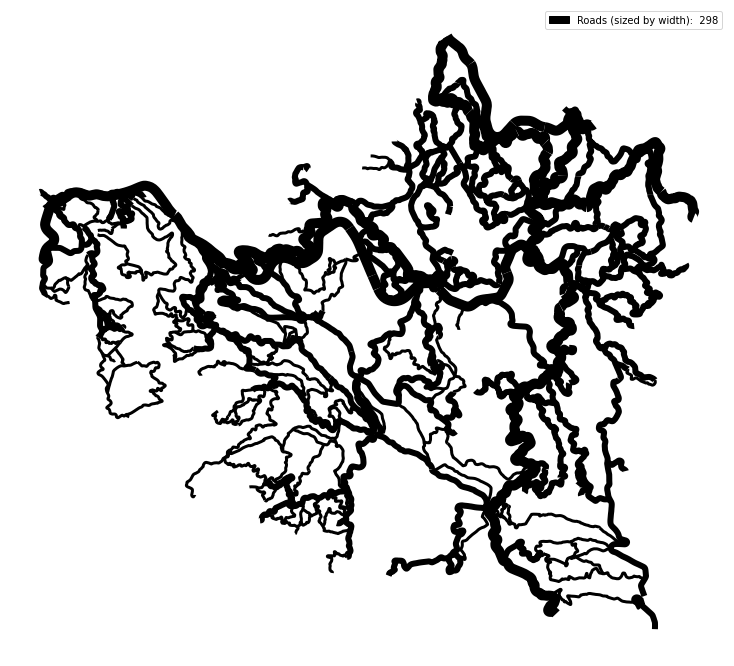

In [28]:
# Display summary statistics for the 'ROADWIDTH' column
print(roads.ROADWIDTH.describe())

# Define a scaling factor for line thickness (adjust as needed)
scaling_factor = 1

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(14, 12))

# Plot the roads with ROADWIDTH > 0 as solid black lines sized by their width
roads[roads['ROADWIDTH'] > 0].plot(color='black', linewidth=roads.ROADWIDTH * scaling_factor, ax=ax, label='Roads (ROADWIDTH > 0)', legend=True)

# Create a custom legend for the categories
handles = [
    mpatches.Patch(color='black', label=f'Roads (sized by width):  {len(roads)}')]   
ax.legend(handles=handles)
ax.axis('off')

# Add title
#plt.title('Roads Sized by Width ("ROADWIDTH")')
plt.show()

In [29]:
roads[['DESIGNACAO','ROADWIDTH']].value_counts()

DESIGNACAO      ROADWIDTH
REM             6            157
RVF             3            111
EN224           10            10
VARIANTE EN222  10             9
EN222           10             7
VARIANTE EN108  10             4
dtype: int64

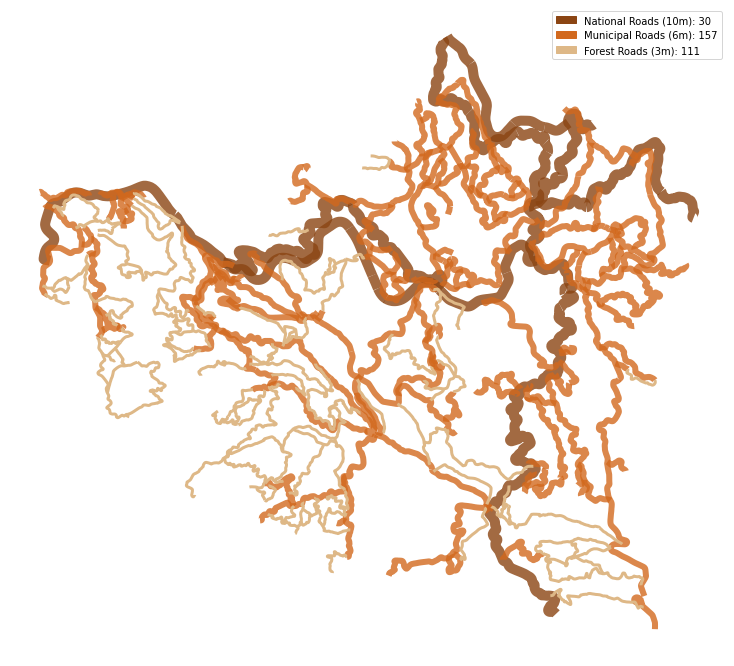

In [30]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(14, 12))

# Define a scaling factor for line thickness (adjust as needed)
scaling_factor = 1

# Plot national roads (ENXXX) as solid lines sized by their width
roads[roads['DESIGNACAO'].str.contains('EN')].plot(
    color='saddlebrown',
    linewidth=roads[roads['DESIGNACAO'].str.contains('EN')]['ROADWIDTH'] * scaling_factor,
    alpha=.8, ax=ax, label='National Roads (ENXXX)')

# Plot municipal roads (REM) as solid lines sized by their width
roads[roads['DESIGNACAO']=='REM'].plot(
    color='chocolate',
    linewidth=roads[roads['DESIGNACAO'] == 'REM']['ROADWIDTH'] * scaling_factor,
    alpha=.8, ax=ax, label='Municipal Roads (REM)')

# Plot other roads (RVF) as  solid lines sized by their width
roads[roads['DESIGNACAO']=='RVF'].plot(
    color='burlywood',
    linewidth=roads[roads['DESIGNACAO'] == 'RVF']['ROADWIDTH'] * scaling_factor,
    ax=ax, label='Other Roads (RVF)')

# Create a custom legend for the categories
handles = [
    mpatches.Patch(color='saddlebrown', label=f'National Roads (10m): {len(roads[roads.ROADWIDTH==10])}'),
    mpatches.Patch(color='chocolate', label=f'Municipal Roads (6m): {len(roads[roads.ROADWIDTH==6])}'),
    mpatches.Patch(color='burlywood', label=f'Forest Roads (3m): {len(roads[roads.ROADWIDTH==3])}')
]
ax.legend(handles=handles)
ax.axis('off')

# Add title
#plt.title('Roads Sized by Width ("ROADWIDTH") and colored by designation ("DESIGNACAO")')
plt.show()

c:\Users\johan\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


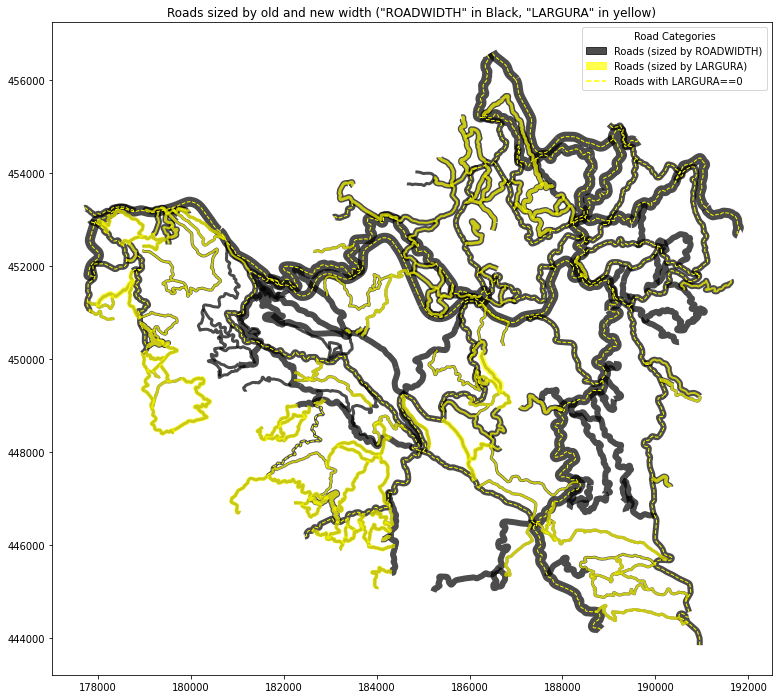

In [31]:
# mixed plot showing both old LARGURA and new ROAD WIdth
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(14, 12))

# Plot the roads with ROADWIDTH > 0 as solid black lines sized by their width
roads[roads['ROADWIDTH'] > 0].plot(color='black', alpha=.7,
                                   linewidth=roads[roads.ROADWIDTH>0]['ROADWIDTH'],
                                   ax=ax, label='Roads (ROADWIDTH > 0)', legend=True)

# Plot the roads with ROADWIDTH = 0 as thin dashed lines
roads[roads['ROADWIDTH'] == 0].plot(color='black', alpha=.7,
                                    linewidth=roads[roads.ROADWIDTH==0]['ROADWIDTH'],
                                    linestyle='--', ax=ax, label='Roads (ROADWIDTH = 0)')

# Plot the roads with LARGURA > 0 as solid lines sized by their width
roads[roads['LARGURA'] > 0].plot(color='yellow', alpha=.7, linewidth=roads['LARGURA'] * scaling_factor, ax=ax, label='Roads (Largura > 0)', legend=True)

# Plot the roads with LARGURA = 0 as thin dashed lines
roads[roads['LARGURA'] == 0].plot(color='yellow', linewidth=1, linestyle='--', ax=ax, label='Roads (Largura = 0)')

# Create a custom legend for the categories
handles = [
    mpatches.Patch(color='black', alpha=.7,label='Roads (sized by ROADWIDTH)'), 
    mpatches.Patch(color='yellow', alpha=.7, label='Roads (sized by LARGURA)'),
    Line2D([0], [0], color='yellow', linestyle='--', label='Roads with LARGURA==0')  # Adding dashed style for unknown
]   
ax.legend(handles=handles, title='Road Categories')

# Add title
plt.title('Roads sized by old and new width ("ROADWIDTH" in Black, "LARGURA" in yellow)')
plt.show()

In [32]:
# Count rows where LARGURA > ROADWIDTH
count_larger = (roads['LARGURA'] > roads['ROADWIDTH']).sum()

# Count rows where LARGURA < ROADWIDTH
count_smaller = ((roads['LARGURA'] < roads['ROADWIDTH']) & (roads['LARGURA']!=0 )).sum()
count_0 = (roads['LARGURA']== 0).sum()

# Count rows where LARGURA == ROADWIDTH
count_equal = (roads['LARGURA'] == roads['ROADWIDTH']).sum()

# Print the results
print("Rows where LARGURA > ROADWIDTH:", count_larger)
print("Rows where LARGURA < ROADWIDTH & LARGURA NONZERO:", count_smaller)
print("Rows where LARGURA == ROADWIDTH:", count_equal)
print("Rows where LARGURA == 0:", count_0)
print('Sum: ', count_larger + count_smaller + count_0 + count_equal)
print('# Roads:', len(roads))


Rows where LARGURA > ROADWIDTH: 17
Rows where LARGURA < ROADWIDTH & LARGURA NONZERO: 183
Rows where LARGURA == ROADWIDTH: 28
Rows where LARGURA == 0: 70
Sum:  298
# Roads: 298


### Step 3. Create two pre-existing road networks:
- "Normal" timber roads (5m),
- Wider timber roads for firefighting access (10m)

Given that the future road network needs to be connected to the existing road network, new timber roads should always connect to existing roads that are at least 3m wide. This is the minimum standard for timber transport.
1. Pre-existing roads need to be at least 3m wide for timber transport
2. For areas with a lower fire resilience, we require a 6m road width for the pre-existing roads.

##### BIGROADS. suitable roads to connect the future 10m-road network to
Since the timber roads we plan to build for low fire resistance stands will be 10 meters wide, it is logical to connect them exclusively to wider roads, in this case a width of 6 meter for pre-existing roads was chosen.

In [33]:
# Filter roads to create df bigroads where roadwidth>=6
bigroads = roads[(roads['ROADWIDTH'] >= 6)].copy()

# How many roads are suitable for big road network connection?
len(bigroads)

187

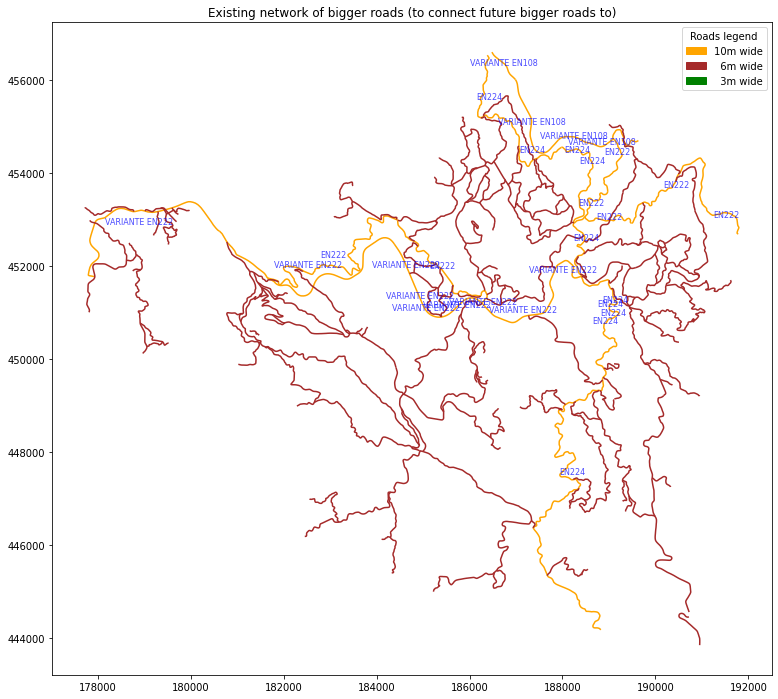

In [34]:
# Plot pre existing road network suitable to be connected with bigger future roads
fig, ax = plt.subplots(figsize=(14, 12))

# Create a new column to categorize the data
bigroads['color'] = 'green'  # Default color
bigroads.loc[bigroads['ROADWIDTH'] >= 10, 'color'] = 'orange'
bigroads.loc[(bigroads['ROADWIDTH'] >= 6) & (bigroads['ROADWIDTH'] < 10), 'color'] = 'brown'

# Plotting
bigroads.plot(color=bigroads['color'], ax=ax, label='Roads (ROADWIDTH > 0)')

# Add road names from the DESIGNACAO column as labels
for idx, row in bigroads.iterrows():
     if 'EN' in row['DESIGNACAO']:
        # Calculate the centroid of each road segment as a position for the label
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        ax.text(x, y, row['DESIGNACAO'], fontsize=8, color='blue', ha='center', alpha=0.7)
        
# Create a custom legend for the categories
handles = [
    mpatches.Patch(color='orange', label='10m wide'),
    mpatches.Patch(color='brown', label='  6m wide'),
    mpatches.Patch(color='green', label='  3m wide')
]
ax.legend(handles=handles, title='Roads legend')

# Add title
plt.title('Existing network of bigger roads (to connect future bigger roads to)')
plt.show()

c:\Users\johan\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


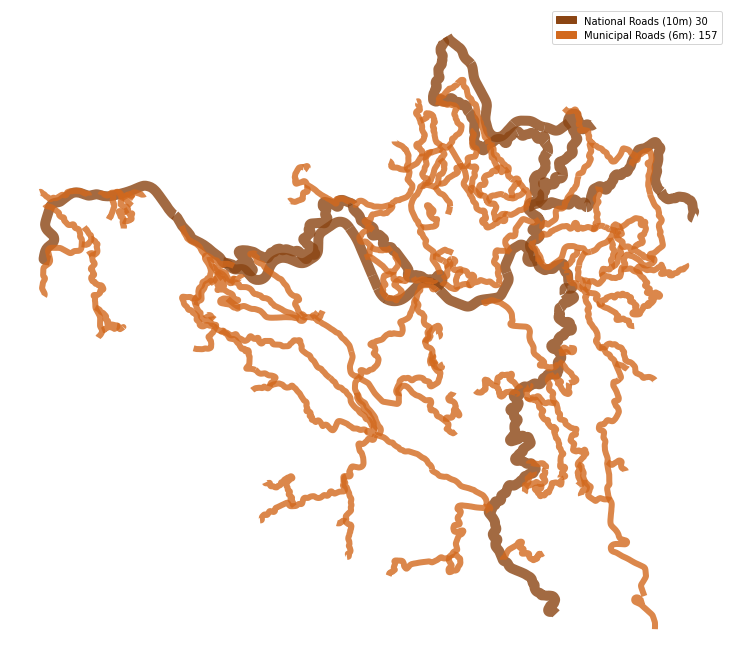

In [35]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(14, 12))

# Define a scaling factor for line thickness (adjust as needed)
scaling_factor = 1

# Plot national roads (ENXXX) as solid lines sized by their width
bigroads[bigroads['DESIGNACAO'].str.contains('EN')].plot(
    color='saddlebrown',
    linewidth=bigroads[bigroads['DESIGNACAO'].str.contains('EN')]['ROADWIDTH'] * scaling_factor,
    alpha=.8, ax=ax, label='National Roads (ENXXX)'
)

# Plot municipal roads (REM) as solid lines sized by their width
bigroads[bigroads['DESIGNACAO'] == 'REM'].plot(
    color='chocolate',
    linewidth=bigroads[bigroads['DESIGNACAO'] == 'REM']['ROADWIDTH'] * scaling_factor,
    alpha=.8, ax=ax, label='Municipal Roads (REM)'
)

# Plot other roads (RVF) as solid lines sized by their width
bigroads[bigroads['DESIGNACAO'] == 'RVF'].plot(
    color='burlywood',
    linewidth=bigroads[bigroads['DESIGNACAO'] == 'RVF']['ROADWIDTH'] * scaling_factor,
    ax=ax, label='Other Roads (RVF)'
)

# Create a custom legend for the categories with value counts
handles = [
    mpatches.Patch(color='saddlebrown', label=f'National Roads (10m) {bigroads["DESIGNACAO"].str.contains("EN").sum()}'),
    mpatches.Patch(color='chocolate', label=f'Municipal Roads (6m): {bigroads["DESIGNACAO"].eq("REM").sum()}'),
    #mpatches.Patch(color='burlywood', label=f'Forest Roads (3m): {bigroads["DESIGNACAO"].eq("RVF").sum()}')
]
ax.legend(handles=handles)
ax.axis('off')

# Add title
#plt.title('Roads Sized by Width ("ROADWIDTH") and colored by designation ("DESIGNACAO")')
plt.show()



##### ROADS. suitable roads to connect future timber road network to
All roads in df roads are >= 3m wide and therefore suitable to be connected to the future timber road network:

In [36]:
print('Number of roads with ROADWIDTH >= 3:',len(roads[(roads['ROADWIDTH'] >= 3)]))
print('Number of roads total:',len(roads))

Number of roads with ROADWIDTH >= 3: 298
Number of roads total: 298


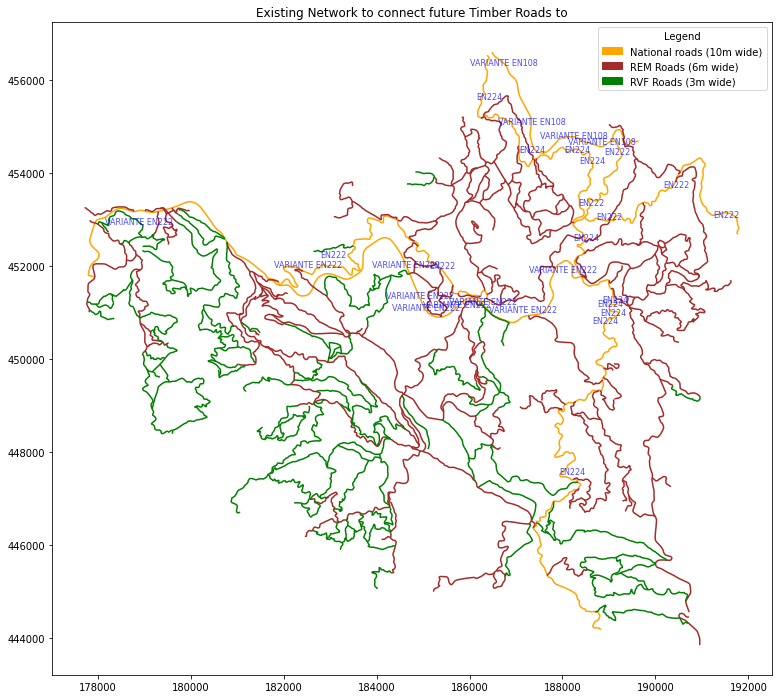

In [37]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(14, 12))

# Plot roads by width categories with different colors
# Roads 10m wide (orange)
roads[roads['ROADWIDTH'] == 10].plot(
    color='orange', ax=ax, label='Roads (10m wide)')

# Roads 6m wide (brown)
roads[roads['ROADWIDTH'] == 6].plot(
    color='brown', ax=ax, label='Roads (6m wide)')

# Roads 3m wide (green)
roads[roads['ROADWIDTH'] == 3].plot(
    color='green', ax=ax, label='Roads (3m wide)')

# Add road names from the DESIGNACAO column as labels
for idx, row in roads.iterrows():
     if 'EN' in row['DESIGNACAO']:
        # Calculate the centroid of each road segment as a position for the label
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        ax.text(x, y, row['DESIGNACAO'], fontsize=8, color='blue', ha='center', alpha=0.7)
        
# Create a custom legend for the categories
handles = [
    mpatches.Patch(color='orange', label='National roads (10m wide)'),
    mpatches.Patch(color='brown', label='REM Roads (6m wide)'),
    mpatches.Patch(color='green', label='RVF Roads (3m wide)')
]
ax.legend(handles=handles, title='Legend')

# Add title
plt.title('Existing Network to connect future Timber Roads to')
plt.show()

### BONUS Step 3.b. Compare Timber and Fire Roads

#### Timber roads

##### REDE DFCI Timber

3    163
1     75
2     60
Name: REDE_DFCI, dtype: int64


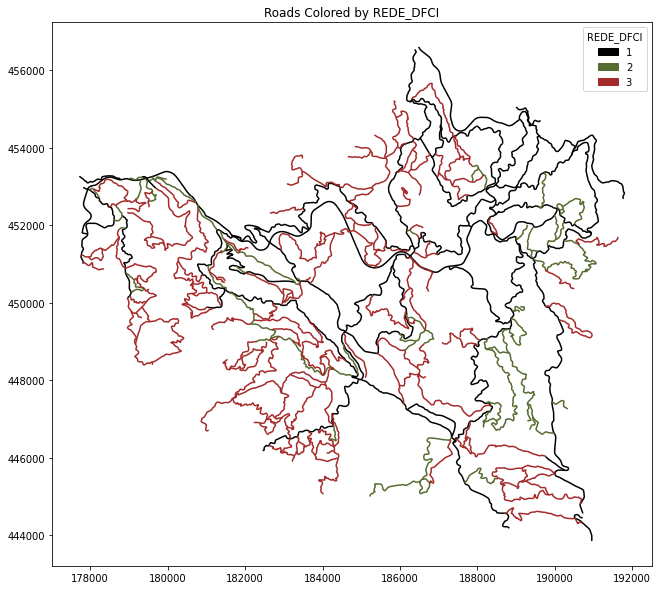

In [38]:
# Display the count of each category in the 'REDE_DFCI' column
print(roads['REDE_DFCI'].value_counts())

# Define a color map for the 'REDE_DFCI' categories
color_map = {
    1: 'black',       # Black for National Roads
    2: '#556B2F',     # Olive Green for Municipal Roads
    3: 'brown'        # Brown for Forest Roads
}

# Apply the color map to the 'REDE_DFCI' column
roads['color'] = roads['REDE_DFCI'].map(color_map)

# Plot the road geometries with specific colors based on the 'REDE_DFCI' values
fig, ax = plt.subplots(figsize=(12, 10))
roads.plot(color=roads['color'], ax=ax)

# Create a custom legend for the categories
handles = [
    mpatches.Patch(color='black', label='1'),  
    mpatches.Patch(color='#556B2F', label='2'), 
    mpatches.Patch(color='brown', label='3')       
]
ax.legend(handles=handles, title='REDE_DFCI')
plt.title('Roads Colored by REDE_DFCI')
plt.show()

##### Surface Timber Roads

##### TIPO_VEHICO Firefighting vehicle types Timber

VFCI    221
VTTR     77
Name: TIPO_VEICU, dtype: int64


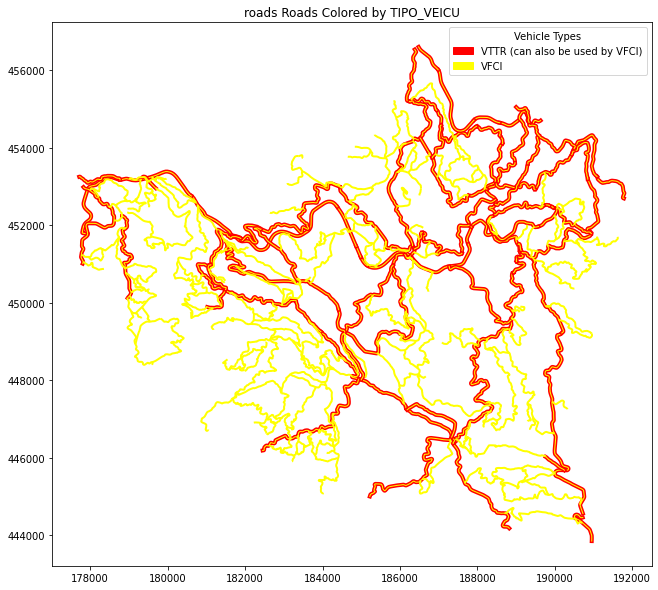

In [39]:
# Display the count of each category in the 'TIPO_VEICU' column
print(roads['TIPO_VEICU'].value_counts())

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Separate the data into two DataFrames based on 'TIPO_VEICU'
vttr_roads = roads[roads['TIPO_VEICU'] == 'VTTR']
vfci_roads = roads[roads['TIPO_VEICU'] == 'VFCI']

# Plot the VTTR roads with double stripes (red and yellow)
for geom in vttr_roads.geometry:
    ax.plot(*geom.xy, color='red', linewidth=4)  # Outer line (red)
    ax.plot(*geom.xy, color='yellow', linewidth=1, alpha=1)  # Inner line (yellow, dashed)

# Plot the VFCI roads as solid yellow lines
vfci_roads.plot(color='yellow', ax=ax, linewidth=2)

# Create a custom legend for the categories
handles = [
    mpatches.Patch(color='red', label='VTTR (can also be used by VFCI)'),  # Color for VTTR
    mpatches.Patch(color='yellow', label='VFCI')  # Color for VFCI
]

ax.legend(handles=handles, title='Vehicle Types')
plt.title('roads Roads Colored by TIPO_VEICU')
plt.show()

#### Fire roads

##### Fire Roads Surface

1    73
3    60
2    54
Name: REDE_DFCI, dtype: int64


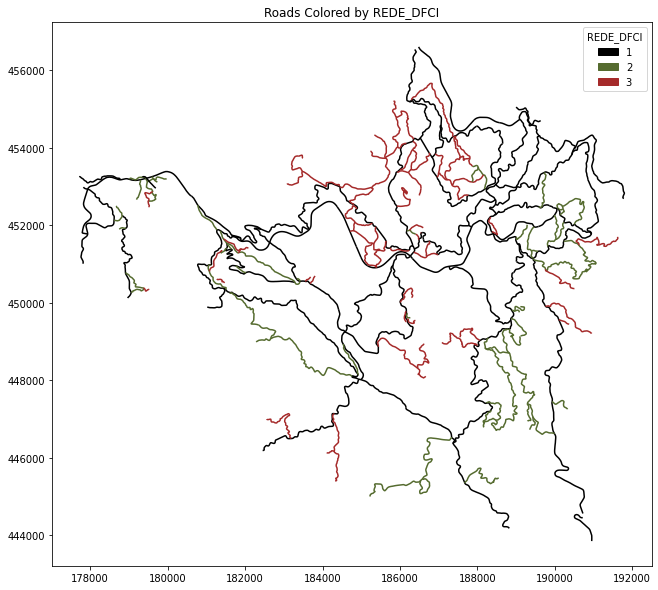

In [40]:
# Fire_roads Display the count of each category in the 'REDE_DFCI' column
print(bigroads['REDE_DFCI'].value_counts())

# Define a color map for the 'REDE_DFCI' categories
color_map = {
    1: 'black',       # Black for National Roads
    2: '#556B2F',     # Olive Green for Municipal Roads
    3: 'brown'        # Brown for Forest Roads
}

# Apply the color map to the 'REDE_DFCI' column
bigroads['color'] = bigroads['REDE_DFCI'].map(color_map)

# Plot the road geometries with specific colors based on the 'REDE_DFCI' values
fig, ax = plt.subplots(figsize=(12, 10))
bigroads.plot(color=bigroads['color'], ax=ax)

# Create a custom legend for the categories
handles = [
    mpatches.Patch(color='black', label='1'),  
    mpatches.Patch(color='#556B2F', label='2'), 
    mpatches.Patch(color='brown', label='3')       
]
ax.legend(handles=handles, title='REDE_DFCI')
plt.title('Roads Colored by REDE_DFCI')
plt.show()

In [41]:
pd.crosstab(roads['DESIGNACAO'], roads['REDE_DFCI'])

REDE_DFCI        1   2    3
DESIGNACAO                 
EN222            7   0    0
EN224           10   0    0
REM             43  54   60
RVF              2   6  103
VARIANTE EN108   4   0    0
VARIANTE EN222   9   0    0

##### TIPO VEICU Fire

VFCI    112
VTTR     75
Name: TIPO_VEICU, dtype: int64


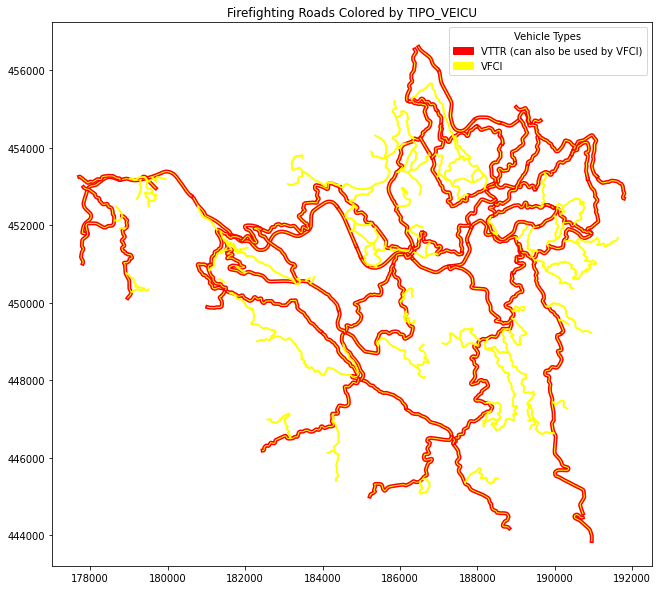

In [42]:
# Display the count of each category in the 'TIPO_VEICU' column
print(bigroads['TIPO_VEICU'].value_counts())

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Separate the data into two DataFrames based on 'TIPO_VEICU'
vttr_roads = bigroads[bigroads['TIPO_VEICU'] == 'VTTR']
vfci_roads = bigroads[bigroads['TIPO_VEICU'] == 'VFCI']

# Plot the VTTR roads with double stripes (red and yellow)
for geom in vttr_roads.geometry:
    ax.plot(*geom.xy, color='red', linewidth=4)  # Outer line (red)
    ax.plot(*geom.xy, color='yellow', linewidth=1, alpha=1)  # Inner line (yellow, dashed)

# Plot the VFCI roads as solid yellow lines
vfci_roads.plot(color='yellow', ax=ax, linewidth=2)

# Create a custom legend for the categories
handles = [
    mpatches.Patch(color='red', label='VTTR (can also be used by VFCI)'),  # Color for VTTR
    mpatches.Patch(color='yellow', label='VFCI')  # Color for VFCI
]

ax.legend(handles=handles, title='Vehicle Types')
plt.title('Firefighting Roads Colored by TIPO_VEICU')
plt.show()


## Prep B. Forest stands

In [84]:
# load shapefile into geodataframe
stands = gpd.read_file('0_Received_Data/1-Forest_Management_Units/CasteloPaiva.shp')
print('shapefile loaded, stands gdf shape:', stands.shape)
print(stands.columns)
stands.head(2)
print('# stands:', len(stands))

shapefile loaded, stands gdf shape: (687, 28)
Index(['OBJECTID', 'TARGET_FID', 'LandUse_1', 'Ocupacao', 'ID_UG', 'NOME',
       'YY_correct', 'XX_Correct', 'Altitude', 'Declive', 'Litologia',
       'Relevo', 'Uso', 'Espessura', 'Apt_flor', 'Solo', 'Classifica',
       'Perimetro', 'Area', 'Hectares', 'UsoSolo20', 'Shape_Leng',
       'Shape_Area', 'HBC', 'CH', 'CBD', 'CC', 'geometry'],
      dtype='object')
# stands: 687


#### Visualize + Basics

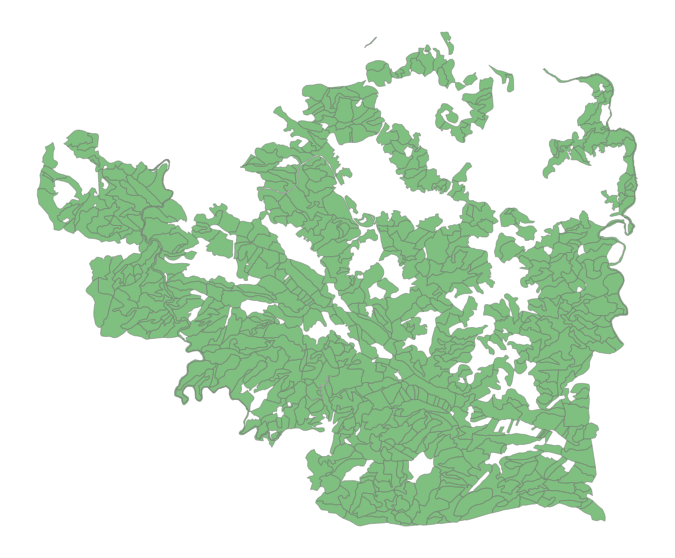

In [77]:
fig, ax = plt.subplots(figsize=(12, 10))  # Adjust the size (width, height) as needed

# Plot the stands with specified colors
stands.plot(ax=ax, edgecolor='grey', facecolor='green', alpha=.5)
# Turn off the axis
ax.axis('off')

# Show the plot
plt.show()

In [45]:
# check for MultiPolygon geometries
len(stands.loc[stands.geometry.type == 'MultiPolygon'])

0

In [46]:
# check for the Polygon geometries
len(stands.loc[stands.geometry.type == 'Polygon'])

687

In [47]:
# Check for duplicate UG_IDs
stands[stands['ID_UG'].duplicated(keep=False)]

Empty GeoDataFrame
Columns: [OBJECTID, TARGET_FID, LandUse_1, Ocupacao, ID_UG, NOME, YY_correct, XX_Correct, Altitude, Declive, Litologia, Relevo, Uso, Espessura, Apt_flor, Solo, Classifica, Perimetro, Area, Hectares, UsoSolo20, Shape_Leng, Shape_Area, HBC, CH, CBD, CC, geometry]
Index: []

[0 rows x 28 columns]

### Step 1. Align the CRS

In [78]:
# Check the CRS of the GeoDataFrames
print('stands CRS:',stands.crs)
print('roads CRS:', roads.crs)

stands CRS: PROJCRS["ETRS89 / Portugal TM06",BASEGEOGCRS["ETRS89",DATUM["European Terrestrial Reference System 1989",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]],ID["EPSG",6258]],PRIMEM["Greenwich",0,ANGLEUNIT["Degree",0.0174532925199433]]],CONVERSION["unnamed",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",39.6682583333333,ANGLEUNIT["Degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-8.13310833333333,ANGLEUNIT["Degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",1,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,3],AXIS["(E)",east,ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["(N)",north,ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["ellipsoidal height (h)",up,ORDER[3],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]

In [79]:
# convert roads CRS to the stands' CRS
bigroads = bigroads.to_crs(stands.crs)
roads = roads.to_crs(stands.crs)

# Check the CRS of the GeoDataFrames
print(stands.crs)
print(roads.crs)
print(bigroads.crs)

PROJCRS["ETRS89 / Portugal TM06",BASEGEOGCRS["ETRS89",DATUM["European Terrestrial Reference System 1989",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]],ID["EPSG",6258]],PRIMEM["Greenwich",0,ANGLEUNIT["Degree",0.0174532925199433]]],CONVERSION["unnamed",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",39.6682583333333,ANGLEUNIT["Degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-8.13310833333333,ANGLEUNIT["Degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",1,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,3],AXIS["(E)",east,ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["(N)",north,ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["ellipsoidal height (h)",up,ORDER[3],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]
PROJCRS["ET

#### Visualize stands and roads together

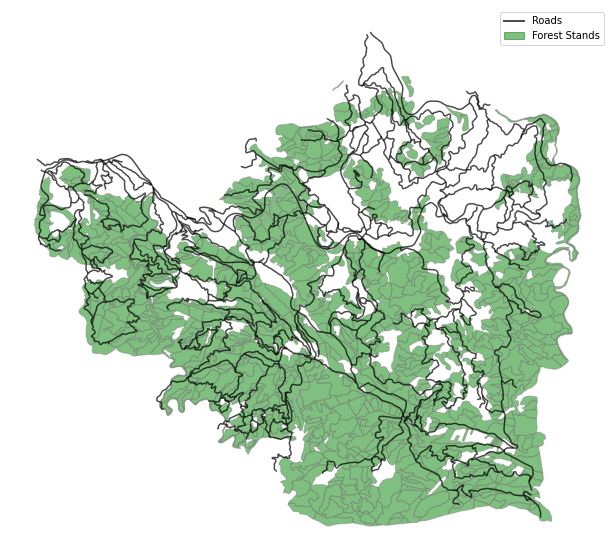

In [50]:
# Create a plot for the forest stands
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the forest stands
stands.plot(ax=ax, color='green', alpha=0.5, label='Forest Stands', edgecolor='grey')

# Plot the roads
roads.plot(ax=ax, color='black', label='Roads', alpha=0.7)

road_line = Line2D([0], [0], color='black', lw=2, label='Roads', alpha=0.7)  # Line for roads
stand_patch = mpatches.Patch(color='green', label='Forest Stands', alpha=0.5)

# Add the legend to the plot
ax.legend(handles=[road_line, stand_patch])
ax.axis('off')

#plt.title('Forest Stands')
plt.show()

### Step 2. Categorize stands according to their accessibility

We wanna create three subsets of stands:
1. the stands crossed by/ touching pre-existing wide roads,
2. the stands unaccessible via wide roads, but crossed by/ touching pre-existing small roads,
3. the stands inaccessible at all.

In [51]:
print("Stands total:", len(stands))

Stands total: 687


#### Accessibility via wide roads

After visualizing, it seems we did not find all stands that are accessible so we try a 10m buffer:

In [52]:
# only big roads
stands_touching_bigroads = stands[stands.geometry.intersects(bigroads.unary_union)]

print("Stands touching bigger roads:")
print(len(stands_touching_bigroads))

# Create a buffer around each road then find stands touching the buffer
bigroads_buffered = bigroads.buffer(10)
stands_touching_bigroads = stands[stands.geometry.intersects(bigroads_buffered.unary_union)]

print("Stands touching bigger roads (with 10m buffer):")
print(len(stands_touching_bigroads))

# subset of stands that are not accessible via firefighting roads yet
not_touching_bigroads = stands[~stands.geometry.intersects(bigroads_buffered.unary_union)]
print("Stands not touching bigger roads:")
print(len(not_touching_bigroads))

Stands touching bigger roads:
314
Stands touching bigger roads (with 10m buffer):
319
Stands not touching bigger roads:
368


In [53]:
# doublecheck the number of stands inaccessible
print('not touching bigger roads:',len(stands[~stands['ID_UG'].isin(stands_touching_bigroads.ID_UG)]))

not touching bigger roads: 368


#### Plot wide road access

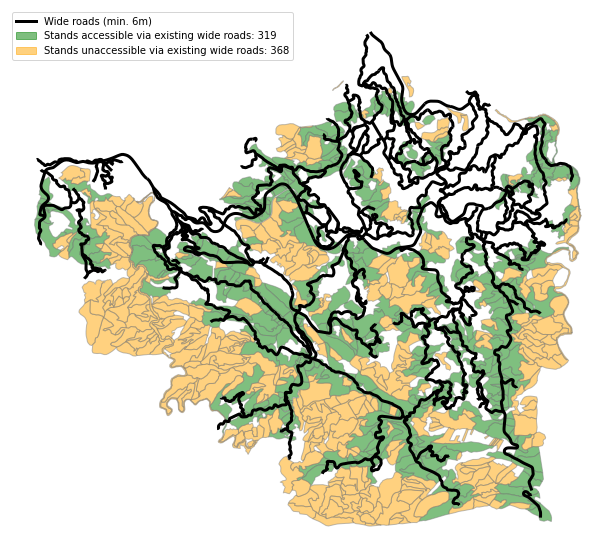

In [63]:
# visualize for big roads
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the roads
bigroads.plot(ax=ax, color='black', label='Roads', lw=3)

# Plot stands
stands_touching_bigroads.plot(ax=ax, color='green', alpha=0.5, edgecolor='grey')
not_touching_bigroads.plot(ax=ax, color='orange', label='Stands', alpha=0.5, edgecolor ='grey')

# Create custom legend handles
road_line = Line2D([0], [0], color='black', lw=3, label='Wide roads (min. 6m)', alpha=1)  # Line for roads
stand_patch = mpatches.Patch(color='orange', label=f'Stands unaccessible via existing wide roads: {len(not_touching_bigroads)}', alpha=0.5)
touching_stand_patch = mpatches.Patch(color='green', label=f'Stands accessible via existing wide roads: {len(stands_touching_bigroads)}', alpha=0.5)

# Add the legend to the plot
ax.legend(handles=[road_line, touching_stand_patch, stand_patch], loc='upper left')
ax.axis('off')

plt.show()

#### Further classification into timber access no access

In [64]:
# continue for stands not touching big roads to split them up into inaccessible and party accessible
stands_timberroadonly = not_touching_bigroads[not_touching_bigroads.geometry.intersects(roads.unary_union)]

print("Stands partly accessible (timber roads only:):")
print(len(stands_timberroadonly))

# Create a buffer around each road then find stands touching the buffer
roads_buffered = roads.buffer(10)
stands_timberroadonly = not_touching_bigroads[not_touching_bigroads.geometry.intersects(roads_buffered.unary_union)]

print("Stands partly accessible (timber roads only, with 10m buffer):")
print(len(stands_timberroadonly))

# subset of stands that are fully inaccessible
not_touching_anyroads = stands[~stands.geometry.intersects(roads_buffered.unary_union)]
print("Stands not touching any roads:")
print(len(not_touching_anyroads))

Stands partly accessible (timber roads only:):
133
Stands partly accessible (timber roads only, with 10m buffer):
139
Stands not touching any roads:
229


#### Plot Timber road access and no access

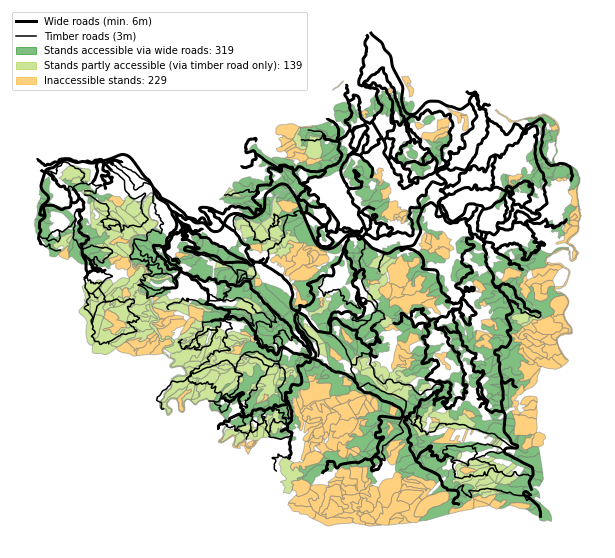

In [ ]:
# visualize for big roads
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the roads
bigroads.plot(ax=ax, color='black', label='Wide roads', lw=3)
roads.plot(ax=ax, color='black', label='Roads', lw=1.5)

# Plot stands
stands_touching_bigroads.plot(ax=ax, color='green', alpha=0.5, edgecolor='grey')
stands_timberroadonly.plot(ax=ax, color='yellowgreen', label='Stands', alpha=0.5, edgecolor ='grey')
not_touching_anyroads.plot(ax=ax, color='orange', label='Stands', alpha=0.5, edgecolor ='grey')

# Create custom legend handles
road_line = Line2D([0], [0], color='black', lw=3, label='Wide roads (min. 6m)', alpha=1)
road_line_small = Line2D([0], [0], color='black', lw=1.5, label='Timber roads (3m)', alpha=1) # Line for roads
stand_patch = mpatches.Patch(color='yellowgreen', label=f'Stands partly accessible (via timber road only): {len(stands_timberroadonly)}', alpha=0.5)
not_patch = mpatches.Patch(color='orange', label=f'Inaccessible stands: {len(not_touching_anyroads)}', alpha=0.5)
touching_stand_patch = mpatches.Patch(color='green', label=f'Stands accessible via wide roads: {len(stands_touching_bigroads)}', alpha=0.5)

# Add the legend to the plot
ax.legend(handles=[road_line, road_line_small, touching_stand_patch, stand_patch, not_patch],
          loc='upper left')
ax.axis('off')

plt.show()

#### Update stands dataframe with new column for accessibility

In [87]:
# create 'access' column in stands based on conditions
stands['road_access'] = stands.ID_UG.apply(
    lambda x: 'timber' if x in stands_timberroadonly.ID_UG.values else (
        'full' if x in stands_touching_bigroads.ID_UG.values else 'none'
    )
)
stands.head(2)

OBJECTID  TARGET_FID  LandUse_1        Ocupacao  ID_UG              NOME  \
0       127         757          1   EcPb_3_9_3_Pv    836  Castelo de Paiva   
1       128         758          1  EcEc_3_10_2_Pv    837  Castelo de Paiva   

      YY_correct    XX_Correct  Altitude  Declive  ...   Hectares  UsoSolo20  \
0  154379.276963  -9216.013743     177.0  16.8833  ...  15.015687  Eucalipto   
1  153027.146729 -21569.125860     151.0  11.6688  ...  17.097563  Eucalipto   

    Shape_Leng     Shape_Area  HBC   CH  CBD   CC  \
0  2215.335044  150156.870494  2.9  0.0  0.0  0.0   
1  2076.935175  170975.628174  2.9  0.0  0.0  0.0   

                                            geometry  road_access  
0  POLYGON ((-8702.645 154274.212, -8663.330 1542...         full  
1  POLYGON ((-21086.044 153014.612, -21132.071 15...       timber  

[2 rows x 29 columns]

In [88]:
stands.road_access.value_counts()

full      319
none      229
timber    139
Name: road_access, dtype: int64

#### Save lists of stands according to accessibility

In [155]:
# Extract 'ID_UG' column and save as CSV files

folder_path = '1_Preprocessed_Data/Stand_Accessibility'

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Save the CSV files in the created folder
stands_touching_bigroads[['ID_UG']].to_csv(f'{folder_path}/stands_accessible.csv', index=False)
stands_timberroadonly[['ID_UG']].to_csv(f'{folder_path}/stands_timberroadonly.csv', index=False)
not_touching_anyroads[['ID_UG']].to_csv(f'{folder_path}/stands_inaccessible.csv', index=False)

In [156]:
stands.to_csv('1_Preprocessed_Data/Stand_Accessibility/stands_total.csv', index=False)

### Check: Are all ID_UG in the harvesting schedule data and vice versa?

In [89]:
presc_stands = pd.read_csv('1_Preprocessed_Data/Lists_of_Stands_Needing_Road_Access/all_UG.csv', index_col=False)

In [90]:
presc_stands.head(2)

UG
0   1
1   2

In [174]:
common_ug = presc_stands.UG.isin(stands.ID_UG)
presc_not_in_stands = presc_stands.UG[~presc_stands.UG.isin(stands.ID_UG)]
stands_not_in_presc = stands.ID_UG[~stands.ID_UG.isin(presc_stands.UG)]

print(f"Common UG values: {common_ug.sum()}")
print(f"Presc Stands not in Stands:\n{presc_not_in_stands.sum()}")
print(f"Stands not in Presc Stands:\n{stands_not_in_presc.sum()}")

Common UG values: 687
Presc Stands not in Stands:
285688
Stands not in Presc Stands:
0


In [175]:
presc_not_in_stands

0        1
1        2
2        3
3        4
4        5
      ... 
715    781
716    782
717    783
718    784
719    785
Name: UG, Length: 719, dtype: int64

In [182]:
common_ug_values = presc_stands.UG[presc_stands.UG.isin(stands.ID_UG)]
print(common_ug_values)


495      549
720      807
721      809
722      810
723      811
        ... 
1401    1618
1402    1620
1403    1622
1404    1623
1405    1626
Name: UG, Length: 687, dtype: int64
